In [1]:
#Run this notebook in the root directory of the project
%cd ../../../

/data/main/2024/GridCellsCond


## Velocity integration curve

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import sim_utils as s_utils
import h5py
from numpy.polynomial import Polynomial
from scipy.interpolate import splrep, BSpline
import seaborn as sns

In [3]:
sim_id = "VALD-PI-VICR-S-m-1a"
dc_range_arr = np.concatenate((np.linspace(-2.7e-3,0,1000,endpoint=False),np.linspace(0,2e-2,200)))
n_trials = 4
sim_num = 0
sim_dur = float(60000)
mult_input_params={}
slopes = np.zeros((len(dc_range_arr),n_trials))
for i,dc in enumerate(dc_range_arr):
    for tr in range(n_trials):
        with h5py.File(f"data/{sim_id}/{sim_id}-slopes.hdf5","r") as f:
            slopes[i,tr]=f[f"{sim_num}"][0]
        sim_num+=1

In [4]:
analysis_start = 21 #start analysis after bump speed is monotonic
slopes = slopes.mean(1)[analysis_start:] 
dc_range_arr = dc_range_arr[analysis_start:]

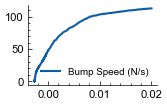

In [16]:
#Plot bump speed vs DC
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(1.662,1.045))
plt.plot(dc_range_arr,slopes*64/(2*np.pi),linewidth=1.5,label="Bump Speed (N/s)")
plt.legend(fontsize=7,loc="lower right")
plt.savefig("analysis/figures/Fig2/Fig2_A_middle.svg")
plt.show()

In [7]:
def is_sorted(arr):
    for i in range(1, len(arr)):
        if arr[i] < arr[i-1]:
            print(arr[i],arr[i-1])
            return False
    return True
def filter_vel_integ(vel_integ):
    """
    Filters the velocity integration array to extract values that maintain an ascending sort.
    Used for interpolation
    
    Args:
        vel_integ (array-like): The velocity integration array.

    Returns:
        tuple: A tuple containing two arrays - the filtered velocity integration values and their corresponding indices w.r.t to original array.

    """
    vel_integ_filtered=[]
    vel_integ_idx=[]
    prev=0
    for i,val in enumerate(vel_integ[:-2]):
        if (prev<vel_integ[i+1]) and (vel_integ[i+1]<vel_integ[i+2]):
            vel_integ_filtered.append(vel_integ[i+1])
            vel_integ_idx.append(i+1)
            prev=vel_integ[i+1]
    return np.array(vel_integ_filtered),np.array(vel_integ_idx)


In [8]:
#Invert function and interpolate
sim_id='VALD-PI-TRAJ-S-m-1a'
params = s_utils.load_sim_params(sim_id)["0"]
slopes_filtered,idx_filtered=filter_vel_integ(slopes) #interpolation requires monotonicity
dc_range_filtered=dc_range_arr[idx_filtered]
tck_s = splrep(slopes_filtered,dc_range_filtered,s=0.00000001)
input_vel= np.linspace(0,10,1000)
dc_out=BSpline(*list(tck_s))(input_vel)
zero_mask = np.abs(input_vel) < 0.0001
other_ring_mask = np.isnan(input_vel)
dc_out[other_ring_mask] = params["vel_integ_or"]

In [9]:
#Save inverted function
spline_params = {}
for i in range(len(tck_s)):
    spline_params[i]=list(tck_s[i]) if isinstance(tck_s[i],np.ndarray) else tck_s[i]
    # spline_params[i]=tck_s[i]
s_utils.json_save(spline_params,"input_data/vi_transform/spline_params.json")

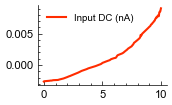

In [10]:
#plot inverted function
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(1.8-0.138,1.2-0.155))
plt.plot(input_vel,dc_out,linewidth=1.5,c="#FF2C00",label="Input DC (nA)")
plt.legend(fontsize=7)
plt.savefig("analysis/figures/Fig2/Fig2_A_left.svg")


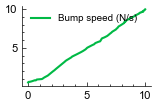

In [11]:
#plot bump speed vs input DC
f=Polynomial.fit(dc_range_arr,slopes,deg=5)
coeffs_bump_speed=np.flip(f.convert().coef)
plt.style.use("analysis/config/paper.mplstyle")
fig,ax=plt.subplots(1,1,figsize=(1.8-0.138,1.2-0.155))
plt.plot(input_vel,np.polyval(coeffs_bump_speed,dc_out),c="#00B945",linewidth=1.5,label="Bump speed (N/s)")
plt.legend(fontsize=7)
plt.savefig("analysis/figures/Fig2/Fig2_A_right.svg")
